In [1]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\keena\Documents\University\python_scripts")

#from Function_files.addresses import Init_Directories

import Function_files.data_functions as dat
from Function_files.math_functions import corrected_pulse_area
from Function_files.plotting_functions import plot_scope
from numpy import divide
from TPA import TPA_config_new as config_file
import os

In [153]:
# import config file dictionary
config = config_file.config_params
config['file'] = r'duration_3'
config['root'] = r"c:\Users\keena\Downloads\0729_TPA\power_3"
dir = os.path.join(config['root'], config['file'])
# get indexes for data channels in the excel files
di = config['data_indexes']
# make labels from data indexes
labels = {key:di[key] for key in di.keys() if key != 'time'}

In [154]:
# interogate directory to extract folder and file names
folder_list, file_list = dat.dir_interrogate(path=dir, extensions=config['extensions'], exceptions=config['exceptions'])
# create dictionary for indexing folders and files
fol_i = dat.make_index_dict(folder_list)
fil_i = [dat.make_index_dict(file_sub_list) for file_sub_list in file_list]
# assemble reference paths
ref_995_path = dat.search_paths(folder_list, file_list, include=config['refs_995'])
ref_1550_path = dat.search_paths(folder_list, file_list, include=config['refs_1550'])
ref_995_path_list = [os.path.join(dir, x) for x in ref_995_path]
ref_1550_path_list = [os.path.join(dir, x) for x in ref_1550_path]
# extract excel data from the folders
data_path_list = dat.search_paths(folder_list, file_list, config['extensions'])
excel_sets = [[dat.open_csv(os.path.join(dir, data_path)) for data_path in data_paths] for data_paths in data_path_list]

In [155]:
# find index of the polarisation values
tpa_pol_1550 = [value for pol in config['pol_1550'] for (key, value) in fol_i.items() if pol in key]
tpa_pol_995 = [value for pol in config['pol_995'] for (key, value) in fol_i.items() if pol in key]
ref_pol_1550 = [value for pol in config['pol_1550'] for (key, value) in fil_i[fol_i['solo_1550']].items() if pol in key]
ref_pol_995 = [value for pol in config['pol_995'] for (key, value) in fil_i[fol_i['solo_995']].items() if pol in key]

# create dictionary for index of polarisation max / min - sp is for the folder index, rsp, rcp are for file indexing
tpa_i = {'tpa_spf': tpa_pol_1550[0],
         'tpa_sps': tpa_pol_1550[1]}

pol_i = {'slow_sp': ref_pol_1550[0],
         'fast_sp': ref_pol_1550[1],
         'slow_cp': ref_pol_995[0],
         'fast_cp': ref_pol_995[1]}

solo_1550


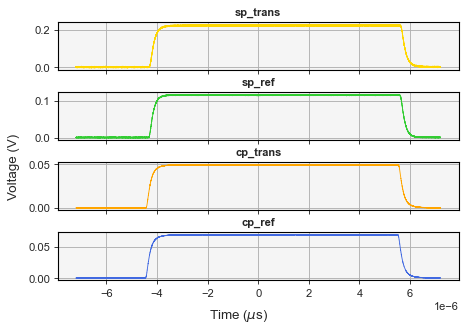

In [156]:
# plot 1550 reference data to check assignment
x = 'solo_1550'
fol = fol_i[x]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(x)

solo_995


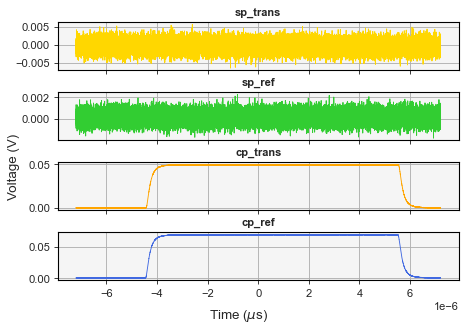

In [157]:
# plot 995 reference data to check assignment
x = 'solo_995'
fol = fol_i[x]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(x)

1550_slow


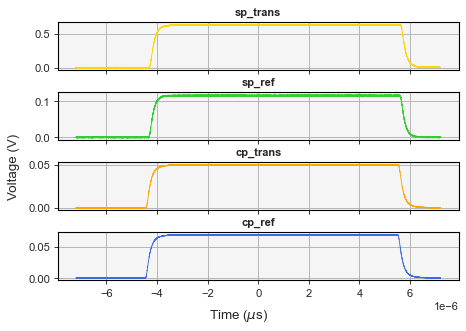

In [158]:
# plot 1550 TPA (fast axis) data to check assignment
name = folder_list[tpa_i['tpa_spf']]
fol = fol_i[name]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(name)

1550_fast


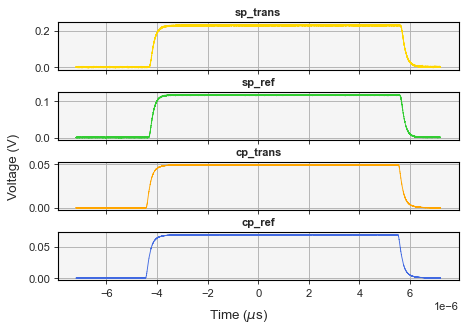

In [159]:
# plot 1550 TPA (slow axis) data to check assignment
name = folder_list[tpa_i['tpa_sps']]
fol = fol_i[name]
fig, ax = plot_scope(excel_sets[fol][0][:,di['time']], [excel_sets[fol][0][:,di['sp_trans']], excel_sets[fol][0][:,di['sp_ref']], excel_sets[fol][0][:,di['cp_trans']], excel_sets[fol][0][:,di['cp_ref']]], titles=labels, multi=True)
print(name)

In [160]:
# time step of scope timebase
dt = (excel_sets[0][0][:,di['time']][1] - excel_sets[0][0][:,di['time']][0])*1E6
# indexes for calculations
area_indexes_cp = [di['cp_trans'], di['cp_ref'], di['time'], 0, round(4/dt)]
# calculate the normalised reference areas
norm_cpf = corrected_pulse_area(excel_sets[fol_i['solo_995']][pol_i['fast_cp']], area_indexes_cp)
norm_cps = corrected_pulse_area(excel_sets[fol_i['solo_995']][pol_i['slow_cp']], area_indexes_cp)
# corrected pulse ratios: (control pulse - leakage)/ reference
cp_corrected = {'cpf_spf': corrected_pulse_area(excel_sets[tpa_i['tpa_spf']][pol_i['fast_cp']], area_indexes_cp, excel_sets[fol_i['solo_1550']][pol_i['fast_sp']]),
            'cpf_sps': corrected_pulse_area(excel_sets[tpa_i['tpa_sps']][pol_i['fast_cp']], area_indexes_cp, excel_sets[fol_i['solo_1550']][pol_i['slow_sp']]),
            'cps_spf': corrected_pulse_area(excel_sets[tpa_i['tpa_spf']][pol_i['slow_cp']], area_indexes_cp, excel_sets[fol_i['solo_1550']][pol_i['fast_sp']]),
            'cps_sps': corrected_pulse_area(excel_sets[tpa_i['tpa_sps']][pol_i['slow_cp']], area_indexes_cp, excel_sets[fol_i['solo_1550']][pol_i['slow_sp']])}

# calculate ratio from pulse areas
cp_ratio = {'cpf_spf': divide(cp_corrected['cpf_spf'], norm_cpf),
        'cpf_sps': divide(cp_corrected['cpf_sps'], norm_cpf),
        'cps_spf': divide(cp_corrected['cps_spf'], norm_cps),
        'cps_sps': divide(cp_corrected['cps_sps'], norm_cps)}

# compile data to save as json dict
save_data_cp = {'area' : cp_corrected,
             'ratio' : cp_ratio}

dat.write_json(os.path.join(dir, config['file'] + '_CP_avg.json'), save_data_cp)

Text(0.02, 0.5, 'Transmission of 995nm Pulses')

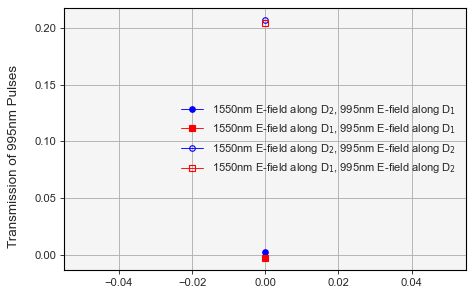

In [161]:
import matplotlib.pyplot as mp

c_axis = dict(

cpf = 1,
cps = 2,
spf = 2,
sps = 1

)

fig, ax = mp.subplots()
ax.plot(cp_ratio['cpf_spf'], fillstyle='full', color='blue', marker='o')
ax.plot(cp_ratio['cpf_sps'], fillstyle='full', color='red', marker='s')
ax.plot(cp_ratio['cps_spf'], fillstyle='none', color='blue', marker='o')
ax.plot(cp_ratio['cps_sps'], fillstyle='none', color='red', marker='s')

ax.legend([f"1550nm E-field along D$_{c_axis['spf']}$, 995nm E-field along D$_{c_axis['cpf']}$", f"1550nm E-field along D$_{c_axis['sps']}$, 995nm E-field along D$_{c_axis['cpf']}$", 
              f"1550nm E-field along D$_{c_axis['spf']}$, 995nm E-field along D$_{c_axis['cps']}$", f"1550nm E-field along D$_{c_axis['sps']}$, 995nm E-field along D$_{c_axis['cps']}$"])

fig.tight_layout(w_pad=2, rect=[0.05, 0.05, 1, 1])

fig.supxlabel('')
fig.supylabel('Transmission of 995nm Pulses')